# South Park Dialogues Analysis And Dialogues To Character Prediction

## Introduction

This notebook is a part of project for university class "PRiAD" (Presentation and Analysis of Data). The main goal of this project is to analyze [South Park](https://en.wikipedia.org/wiki/South_Park) dialogues and predict which character said which dialogue. The dataset used in this project is available on Kaggle: https://www.kaggle.com/tovarischsukhov/southparklines. The dataset contains 70896 dialogues from 18 seasons of South Park. The dataset contains the following columns: Season, Episode, Character, Line. The dataset is in CSV format.

## Goals

The main goals of this project are:
- Analyze South Park dialogues and find interesting patterns
- Build a model that predicts which character said which dialogue
- Evaluate the model

## Tools

The following tools will be used in this project:
- Python
- Pandas
- Numpy
- Matplotlib
- Seaborn
- nltk
- re
- WordCloud
- ***And more to come...***

## Libraries and setup

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\golas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\golas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data insides


In [255]:
raw_data = pd.read_csv("data/SouthParkData.csv", encoding="utf-8", header=0)

raw_data.head(10)

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away. \n"
1,10,1,Kyle,Going away? For how long?\n
2,10,1,Stan,Forever.\n
3,10,1,Chef,I'm sorry boys.\n
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."
5,10,1,Chef,Wow!\n
6,10,1,Mrs. Garrison,Chef?? What kind of questions do you think adv...
7,10,1,Chef,What's the meaning of life? Why are we here?\n
8,10,1,Mrs. Garrison,I hope you're making the right choice.\n
9,10,1,Cartman,I'm gonna miss him. I'm gonna miss Chef and I...


## Data cleaning and preprocessing

In [256]:
print(f"Null object in data set:\n {raw_data.isnull().sum()}")
print(f"Na object in data set:\n {raw_data.isna().sum()}")

df = raw_data.dropna()

Null object in data set:
 Season       0
Episode      0
Character    0
Line         0
dtype: int64
Na object in data set:
 Season       0
Episode      0
Character    0
Line         0
dtype: int64


The dataset doesnt contain any null or na values.

In [257]:
df["Line"] = df["Line"].str.replace("\n", "")
df.head(5)

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away."
1,10,1,Kyle,Going away? For how long?
2,10,1,Stan,Forever.
3,10,1,Chef,I'm sorry boys.
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."


The new line character ( '\n' ) can be safely removed from the "Line" column as it will not be useful in the analysis and model building.

In [258]:
df["Line"] = df["Line"].str.lower()
df["Line"] = df["Line"].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df.head(5)

,Season,Episode,Character,Line
0,10,1,Stan,you guys you guys chef is going away
1,10,1,Kyle,going away for how long
2,10,1,Stan,forever
3,10,1,Chef,im sorry boys
4,10,1,Stan,chef said hes been bored so he joining a group...


The "Line" column is converted to lowercase and all punctuation characters are removed from the column.

In [259]:
stop_words = set(stopwords.words("english"))

df["Line"] = df["Line"].apply(lambda x: " ".join([word for word in word_tokenize(x) if word.lower() not in stop_words]))
df.head(5)

,Season,Episode,Character,Line
0,10,1,Stan,guys guys chef going away
1,10,1,Kyle,going away long
2,10,1,Stan,forever
3,10,1,Chef,im sorry boys
4,10,1,Stan,chef said hes bored joining group called super...


The stop words are removed from the "Line" column to reduce dimensionality and improve the quality of the analysis and model.

In [260]:
df = df[df["Line"].str.strip().astype(bool)]
df = df[df.Season != "Season"]
df = df[df.Episode != "Episode"]
df = df[df.Character != "Character"]

The empty lines are removed from the dataset. And the rows with "Season", "Episode" and "Character" values are removed.

In [261]:
# remove characters with less than 10 dialogues
characters_count = df["Character"].value_counts()
characters_to_remove = characters_count[characters_count < 10].index

df = df[~df["Character"].isin(characters_to_remove)]
#show top 10 characters
characters_to_remove = pd.Series(characters_to_remove)
characters_to_remove.head(5)

0         Mr. Kitty
1          Sergeant
2        Anchor Tom
3    Mrs. Cotswolds
4      Talent Scout
Name: Character, dtype: object

The characters with less than 10 dialogues are removed from the dataset as they cannot be used appropriately in distinguishing the characters.

## Data analysis

Analysis of the preprocessed dataset to find interesting patterns and insights.

In [262]:
df.describe(include="all")

,Season,Episode,Character,Line
count,60800,60800,60800,60800
unique,18,18,710,51961
top,2,10,Cartman,yeah
freq,5670,4620,9550,459


After brief look at the data, we can see that there are 60800 dialogues in the dataset. The dataset contains 4 columns: Season, Episode, Character, Line. The dataset contains 18 seasons of South Park with the most frequent being season 2 with 5670 dialogues. The dataset contains 710 unique characters. The most frequent character is "Cartman" with 9550 dialogues.

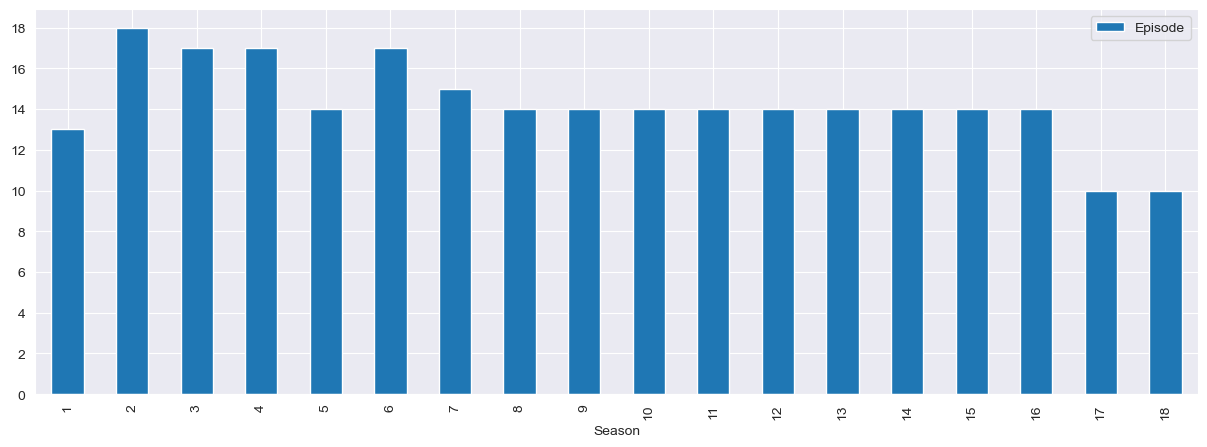

In [263]:
episodes_count = df.groupby("Season")["Episode"].nunique()
episodes_count = episodes_count.sort_index(key=lambda x: x.astype(int)).reset_index()

episodes_count.plot(kind="bar", x="Season", y="Episode", figsize=(15, 5))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

The plot above shows the number of episodes in each season. The number of episodes in each season varies from 10 to 18.

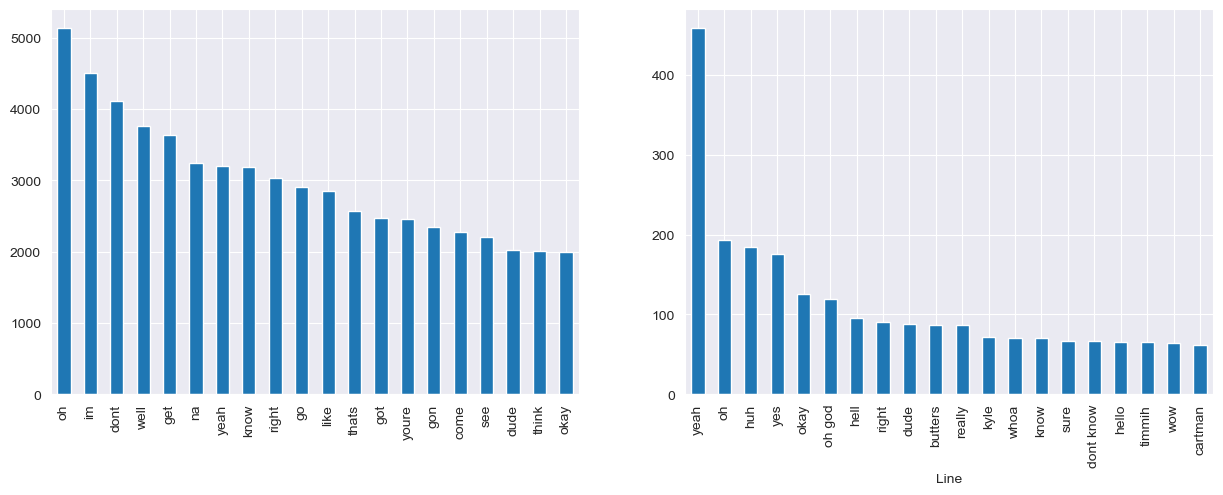

In [264]:
most_common_words = pd.Series(" ".join(df["Line"]).split()).value_counts()[:20]
most_common_lines = df["Line"].value_counts()[:20]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
most_common_words.plot(kind="bar", ax=ax[0])
most_common_lines.plot(kind="bar", ax=ax[1])

plt.show()

The plot above shows the 20 most common words and lines in the dataset. The most common word is "oh" and the most common line is "yeah". 

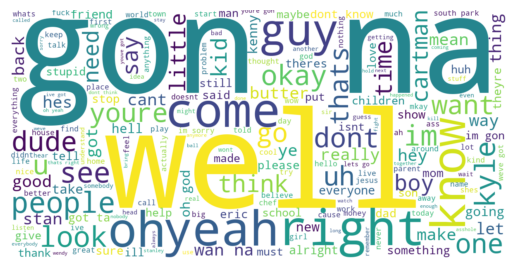

In [265]:
word_cloud = WordCloud(width=1200, height=600, background_color="white").generate(" ".join(df["Line"]))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")

plt.show()

The word cloud above highlights the various keywords present in the dataset. Larger words indicate more frequent occurrences, while smaller ones represent less common terms. This visualization helps identify dominant themes and trends within the data more precisely.

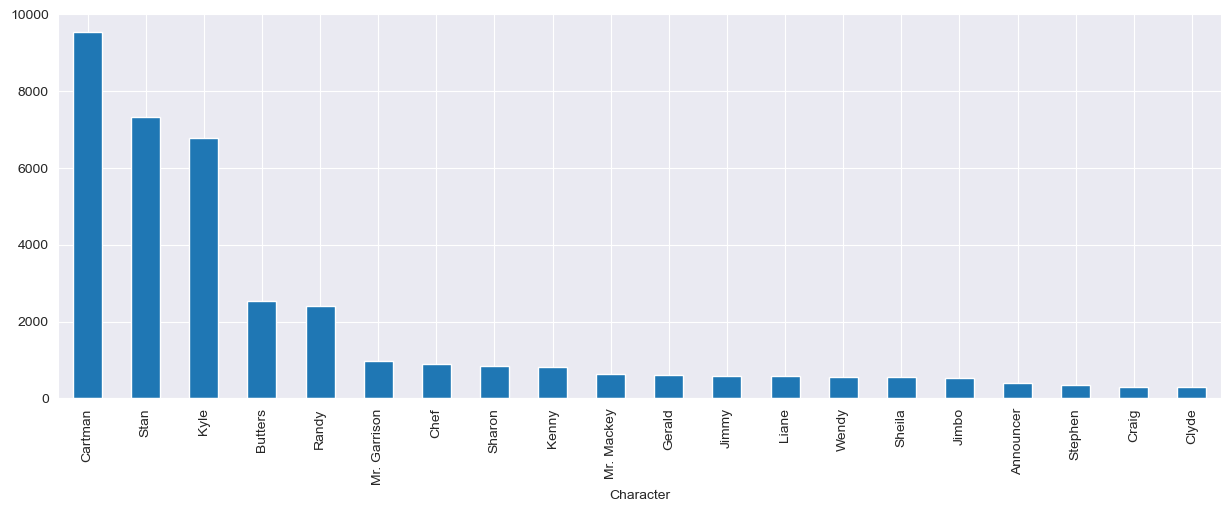

In [266]:
characters_count = df["Character"].value_counts()
least_common_characters = characters_count[characters_count == 10]
most_common_characters = characters_count[:20]

most_common_characters.plot(kind="bar", figsize=(15, 5))

plt.show()

The plot above shows the 20 most common characters in the dataset. The most common characters are "Cartman", "Stan" and "Kyle" as they are the main characters in show.

In [267]:
least_common_characters = characters_count[characters_count == 10]
least_common_characters

Character
Husband        10
Porsche        10
Cody           10
Ballmer        10
Fiancée        10
               ..
Tuong          10
Females        10
Catatafish     10
Marcus         10
P.F. Pityef    10
Name: count, Length: 62, dtype: int64

The characters with the least dialogues are shown above. There are 62 characters with 10 dialogues which is the least that a character can have that are allowed in the dataset.